# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**. Please check the deadline on moodle!
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "yuanjie"
ln1 = "zhao"
fn2 = "alexandre"
ln2 = "gramfort"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_zhao_yuanjie_and_jiao_liyao.ipynb


In [1]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

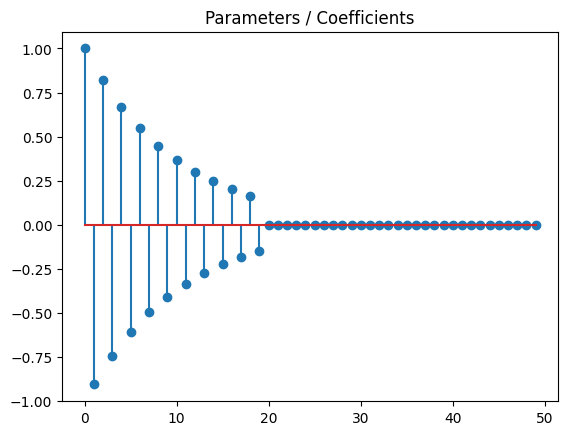

In [3]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg import toeplitz


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
         Correlation between features i and j is corr^|i - j|


    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + np.random.randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation between features i and j is corr^|i - j|

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [6]:
A, b = simu_linreg(coefs)
# A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{(\lambda \,R)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization, where $R(z) = \frac{1}{2} \|z\|_2^2$
- L1 penalization, where $R(z) =  \|z|\|_1$

where $\lambda > 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the L2 and L1 
    </li>
    </ul>
</div>

In [8]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""    
    return np.sign(x) * np.maximum(0, np.abs(x) - lmbd) # TODO
    
def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd * np.linalg.norm(x, ord=1) # TODO

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""    
    return 1 / (1 + lmbd) * x # TODO
    
def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return lmbd * np.linalg.norm(x, ord=2) / 2 # TODO

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2.0, 2.0)

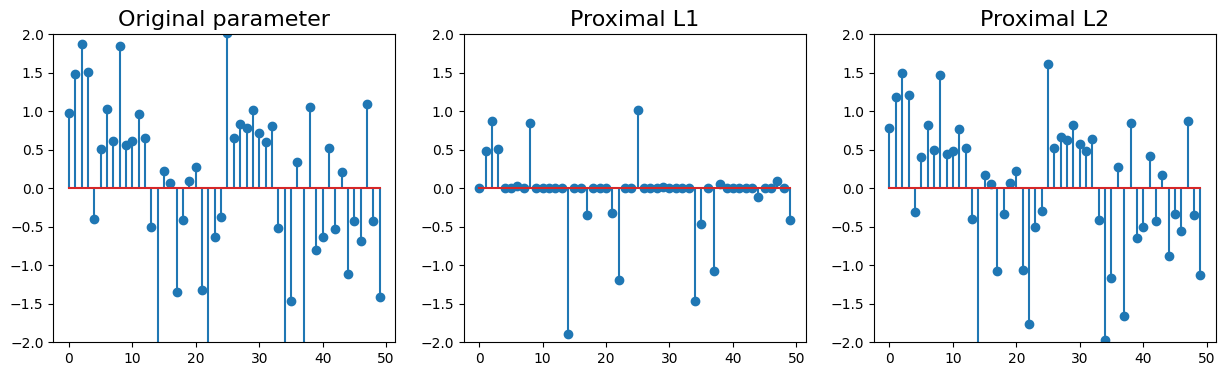

In [9]:
x = np.random.randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

When we perform the L1 proximal, we actually perform a soft shrinkage: the values whose absolute value is smaller than $\lambda$ are reduced to $0$ and the others' absolute values are reduced by $\lambda$.

When we perform the L2 proximal, we actually perform a scaling. The values are multiplied by $\frac{1}{1+\lambda}$ without setting any non-zero ones to zero.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ has a simple proximal operator.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A = [a_1,\ldots, a_n]^{\top} \in \mathbb{R}^{n \times d}$ is the matrix of samples.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [14]:
def loss_linreg(x):
    """Least-squares loss"""
    # TODO
    return 1 / (2 * n_samples) * np.linalg.norm(b - A @ x, ord=2) ** 2

def grad_linreg(x):
    """Least-squares gradient"""
    # TODO
    return 1 / n_samples * A.T @ (A @ x - b)

def loss_logreg(x):
    """Logistic loss"""
    # TODO
    return np.mean([np.log(1 + np.exp(-b[i] * A[i] @ x)) for i in range(n_samples)])

def grad_logreg(x):
    """Logistic gradient"""
    # TODO
    return np.mean([-b[i] * A[i] / (1 + np.exp(b[i] * A[i] @ x)) for i in range(n_samples)], axis=0)

# TO BE COMPLETED

In [16]:
from scipy.optimize import check_grad

x = np.random.randn(n_features)

A, b = simu_linreg(coefs)
print('Check gradient for least-squares', check_grad(loss_linreg, grad_linreg, x))

A, b = simu_logreg(coefs)
print('Check gradient for logistic loss', check_grad(loss_logreg, grad_logreg, x))

Check gradient for least-squares 3.606869382859956e-06
Check gradient for logistic loss 2.4605635510574034e-07


## Part 3: Solvers

We now have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_R$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD(Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [44]:
# TO BE COMPLETED

# Calculate the smoothness constant for L2
def smoothness_const_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    # TODO
    return np.linalg.norm(A, ord=2) ** 2 / n_samples
# Calculate the smoothness constant for Logistic loss   
def smoothness_const_logreg(A):
    """Lipschitz constant for logistic loss"""    
    # TODO
    return np.linalg.norm(A, ord=2) ** 2 / (4 * n_samples)
    
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        
        y = x - step * grad_f(x)
        x = prox_R(y, lmbd * step)
        
        obj = f(x) + R(x, lmbd)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [18]:
# TO BE COMPLETED

def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x_new = prox_R(z - step * grad_f(z), lmbd * step)
        t_new = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        z = x_new + (t - 1) / t_new * (x_new - x)
        
        x = x_new
        t = t_new

        obj = f(x) + R(x, lmbd)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [49]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 1000
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with L2 
  penalization problem using the parameters give above. This can be done by using APGD with 
  1000 iterations.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [50]:
x_PGD, obj_PGD, err_PGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1 / smoothness_const_linreg(A), lmbd, n_iter)

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 4.47e-01 | 9.57e-01
      10 | 3.54e-01 | 7.56e-01
      20 | 3.46e-01 | 6.98e-01
      30 | 3.45e-01 | 6.78e-01
      40 | 3.45e-01 | 6.72e-01
      50 | 3.45e-01 | 6.69e-01
      60 | 3.45e-01 | 6.68e-01
      70 | 3.45e-01 | 6.68e-01
      80 | 3.45e-01 | 6.68e-01
      90 | 3.45e-01 | 6.68e-01
     100 | 3.45e-01 | 6.68e-01
     110 | 3.45e-01 | 6.68e-01
     120 | 3.45e-01 | 6.68e-01
     130 | 3.45e-01 | 6.68e-01
     140 | 3.45e-01 | 6.68e-01
     150 | 3.45e-01 | 6.68e-01
     160 | 3.45e-01 | 6.68e-01
     170 | 3.45e-01 | 6.68e-01
     180 | 3.45e-01 | 6.68e-01
     190 | 3.45e-01 | 6.68e-01
     200 | 3.45e-01 | 6.68e-01
     210 | 3.45e-01 | 6.68e-01
     220 | 3.45e-01 | 6.68e-01
     230 | 3.45e-01 | 6.68e-01
     240 | 3.45e-01 | 6.68e-01
     250 | 3.45e-01 | 6.68e-01
     260 | 3.45e-01 | 6.68e-01
     270 | 3.45e-01 | 6.68e-01
     280 | 3.45e-01 | 6.68e-01
     290 | 3.45e-01 | 6.68e-01
     300 | 3.45e-

In [51]:
x_APGD, obj_APGD, err_APGD = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1 / smoothness_const_linreg(A), lmbd, n_iter)

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 4.47e-01 | 9.57e-01
      10 | 3.46e-01 | 6.67e-01
      20 | 3.45e-01 | 6.68e-01
      30 | 3.45e-01 | 6.68e-01
      40 | 3.45e-01 | 6.68e-01
      50 | 3.45e-01 | 6.68e-01
      60 | 3.45e-01 | 6.68e-01
      70 | 3.45e-01 | 6.68e-01
      80 | 3.45e-01 | 6.68e-01
      90 | 3.45e-01 | 6.68e-01
     100 | 3.45e-01 | 6.68e-01
     110 | 3.45e-01 | 6.68e-01
     120 | 3.45e-01 | 6.68e-01
     130 | 3.45e-01 | 6.68e-01
     140 | 3.45e-01 | 6.68e-01
     150 | 3.45e-01 | 6.68e-01
     160 | 3.45e-01 | 6.68e-01
     170 | 3.45e-01 | 6.68e-01
     180 | 3.45e-01 | 6.68e-01
     190 | 3.45e-01 | 6.68e-01
     200 | 3.45e-01 | 6.68e-01
     210 | 3.45e-01 | 6.68e-01
     220 | 3.45e-01 | 6.68e-01
     230 | 3.45e-01 | 6.68e-01
     240 | 3.45e-01 | 6.68e-01
     250 | 3.45e-01 | 6.68e-01
     260 | 3.45e-01 | 6.68e-01
     270 | 3.45e-01 | 6.68e-01
     280 | 3.45e-01 | 6.68e-01
     290 | 3.45e-01 | 6.68e-01
     300 | 3.45

Minimum and minimizer:

In [52]:
x_PGD, obj_PGD[-1]

(array([ 0.35, -0.35,  0.29, -0.22,  0.2 , -0.19,  0.17, -0.19,  0.11,
        -0.16,  0.12, -0.16,  0.09, -0.1 ,  0.08, -0.12,  0.12, -0.06,
         0.01, -0.08,  0.03, -0.04,  0.06, -0.03,  0.04,  0.03, -0.06,
         0.08, -0.07, -0.  , -0.01,  0.04, -0.01,  0.05, -0.05,  0.08,
        -0.09,  0.08,  0.  ,  0.02,  0.06,  0.03, -0.1 ,  0.06,  0.01,
        -0.03,  0.03,  0.  , -0.05,  0.01]),
 0.345357682885561)

In [53]:
x_APGD, obj_APGD[-1]

(array([ 0.35, -0.35,  0.29, -0.22,  0.2 , -0.19,  0.17, -0.19,  0.11,
        -0.16,  0.12, -0.16,  0.09, -0.1 ,  0.08, -0.12,  0.12, -0.06,
         0.01, -0.08,  0.03, -0.04,  0.06, -0.03,  0.04,  0.03, -0.06,
         0.08, -0.07, -0.  , -0.01,  0.04, -0.01,  0.05, -0.05,  0.08,
        -0.09,  0.08,  0.  ,  0.02,  0.06,  0.03, -0.1 ,  0.06,  0.01,
        -0.03,  0.03,  0.  , -0.05,  0.01]),
 0.3453576828855609)

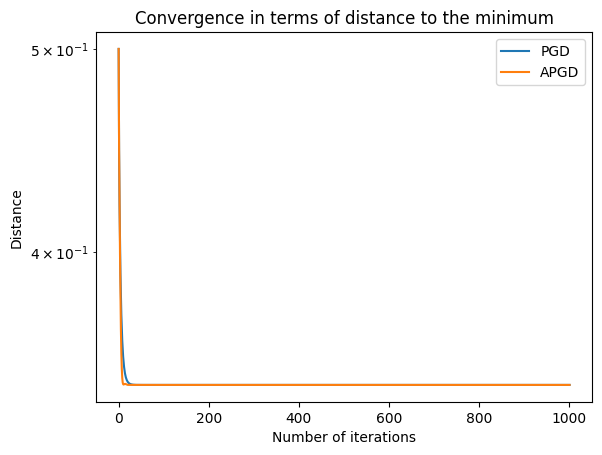

In [54]:
plt.title('Convergence in terms of distance to the minimum')
plt.plot(obj_PGD, label="PGD")
plt.plot(obj_APGD, label="APGD")
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Distance')
plt.legend()

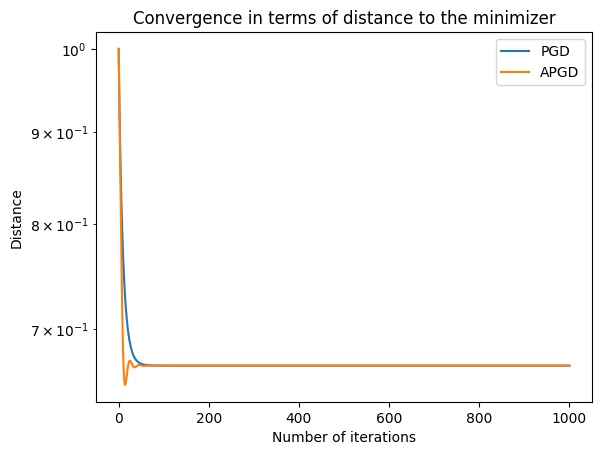

In [55]:
plt.title('Convergence in terms of distance to the minimizer')
plt.plot(err_PGD, label="PGD")
plt.plot(err_APGD, label="APGD")
plt.yscale('log')
plt.xlabel('Number of iterations')
plt.ylabel('Distance')
plt.legend()

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of
  the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.</li>
    <li> Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of  
  penalization ($\lambda$) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when $\lambda$ increases.</li>
    </ul>
</div>

Let's pick logistic for the first question.

Logistic, L1:

In [56]:
x_PGD, obj_PGD, err_PGD = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, 1 / smoothness_const_logreg(A), lmbd, n_iter)
x_APGD, obj_APGD, err_APGD = APGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, 1 / smoothness_const_logreg(A), lmbd, n_iter)

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 6.59e-01 | 9.30e-01
      10 | 6.01e-01 | 6.24e-01
      20 | 5.94e-01 | 5.16e-01
      30 | 5.93e-01 | 4.68e-01
      40 | 5.92e-01 | 4.45e-01
      50 | 5.92e-01 | 4.34e-01
      60 | 5.92e-01 | 4.28e-01
      70 | 5.92e-01 | 4.25e-01
      80 | 5.92e-01 | 4.23e-01
      90 | 5.92e-01 | 4.22e-01
     100 | 5.92e-01 | 4.22e-01
     110 | 5.92e-01 | 4.22e-01
     120 | 5.92e-01 | 4.22e-01
     130 | 5.92e-01 | 4.22e-01
     140 | 5.92e-01 | 4.22e-01
     150 | 5.92e-01 | 4.22e-01
     160 | 5.92e-01 | 4.22e-01
     170 | 5.92e-01 | 4.22e-01
     180 | 5.92e-01 | 4.22e-01
     190 | 5.92e-01 | 4.22e-01
     200 | 5.92e-01 | 4.22e-01
     210 | 5.92e-01 | 4.22e-01
     220 | 5.92e-01 | 4.22e-01
     230 | 5.92e-01 | 4.22e-01
     240 | 5.92e-01 | 4.22e-01
     250 | 5.92e-01 | 4.22e-01
     260 | 5.92e-01 | 4.22e-01
     270 | 5.92e-01 | 4.22e-01
     280 | 5.92e-01 | 4.22e-01
     290 | 5.92e-01 | 4.22e-01
     300 | 5.92e-

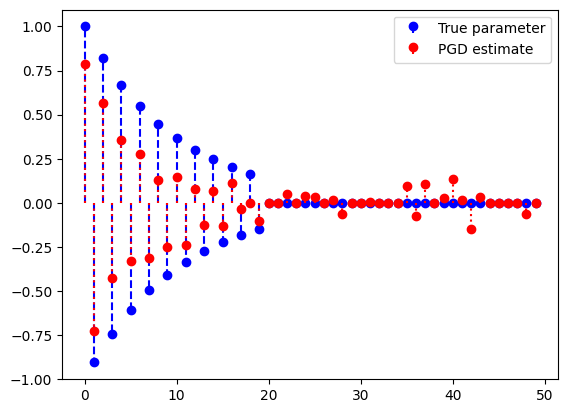

In [57]:
plt.stem(coefs, label="True parameter", linefmt='b--', markerfmt='bo', basefmt=' ')
plt.stem(x_PGD, label="PGD estimate", linefmt='r:', markerfmt='ro', basefmt=' ')
plt.legend()

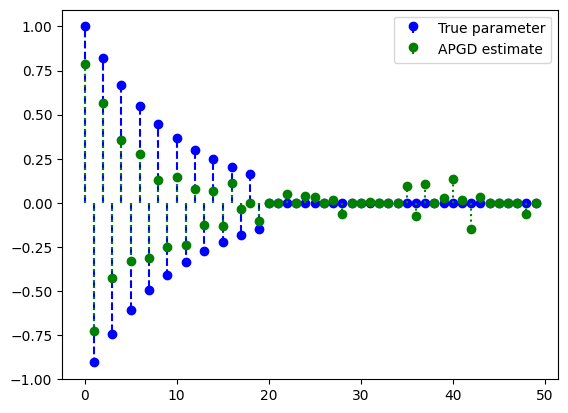

In [58]:
plt.stem(coefs, label="True parameter", linefmt='b--', markerfmt='bo', basefmt=' ')
plt.stem(x_APGD, label="APGD estimate", linefmt='g:', markerfmt='go', basefmt=' ')
plt.legend()

Logistic, L2:

In [59]:
x_PGD, obj_PGD, err_PGD = PGD(x0, loss_logreg, grad_logreg, L2_norm, prox_L2, 1 / smoothness_const_logreg(A), lmbd, n_iter)
x_APGD, obj_APGD, err_APGD = APGD(x0, loss_logreg, grad_logreg, L2_norm, prox_L2, 1 / smoothness_const_logreg(A), lmbd, n_iter)

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 6.41e-01 | 9.17e-01
      10 | 5.39e-01 | 5.31e-01
      20 | 5.23e-01 | 4.15e-01
      30 | 5.18e-01 | 3.76e-01
      40 | 5.16e-01 | 3.62e-01
      50 | 5.15e-01 | 3.58e-01
      60 | 5.15e-01 | 3.56e-01
      70 | 5.14e-01 | 3.55e-01
      80 | 5.14e-01 | 3.55e-01
      90 | 5.14e-01 | 3.55e-01
     100 | 5.14e-01 | 3.55e-01
     110 | 5.14e-01 | 3.55e-01
     120 | 5.14e-01 | 3.55e-01
     130 | 5.14e-01 | 3.55e-01
     140 | 5.14e-01 | 3.55e-01
     150 | 5.14e-01 | 3.55e-01
     160 | 5.14e-01 | 3.55e-01
     170 | 5.14e-01 | 3.55e-01
     180 | 5.14e-01 | 3.55e-01
     190 | 5.14e-01 | 3.55e-01
     200 | 5.14e-01 | 3.55e-01
     210 | 5.14e-01 | 3.55e-01
     220 | 5.14e-01 | 3.55e-01
     230 | 5.14e-01 | 3.55e-01
     240 | 5.14e-01 | 3.55e-01
     250 | 5.14e-01 | 3.55e-01
     260 | 5.14e-01 | 3.55e-01
     270 | 5.14e-01 | 3.55e-01
     280 | 5.14e-01 | 3.55e-01
     290 | 5.14e-01 | 3.55e-01
     300 | 5.14e-

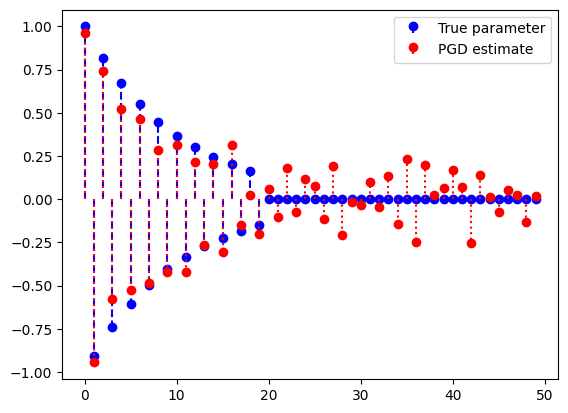

In [60]:
plt.stem(coefs, label="True parameter", linefmt='b--', markerfmt='bo', basefmt=' ')
plt.stem(x_PGD, label="PGD estimate", linefmt='r:', markerfmt='ro', basefmt=' ')
plt.legend()

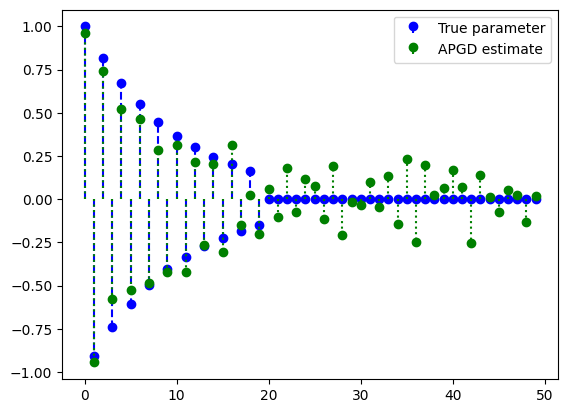

In [61]:
plt.stem(coefs, label="True parameter", linefmt='b--', markerfmt='bo', basefmt=' ')
plt.stem(x_APGD, label="APGD estimate", linefmt='g:', markerfmt='go', basefmt=' ')
plt.legend()

We can see that the results get from PGD and APGD are quite close to each other.

We can see that the coefficients whose true value is $0$ are close to $0$ in terms of L1 regularization, but tend to fluctuate in terms of L2 regularization. This is due to the same characteristics of the proximal operator of L1 and L2: L1 performs a soft shrinkage while L2 performs a scaling.

For the second question, let's pick logistic and L1.

From the plot above for L1, we observe that the coefficients whose true value is not $0$ becomes smaller than the true value. This is because L1 has a regularization term whose aim is to let the magnitude of the coefficients not become too big.

On the other hand, we observe that the coefficients whose true value is $0$ becomes quite close to $0$ in the final result, which is due to the soft shrinkage of proximal operator of L1: coefficients whose absolute value is smaller than the threshold are shrunk to $0$ while the absolute values of others are subtracted by the threshold.

For the third question, let's pick linear regression and L2 regularizor.

$\lambda=0.0001$:

In [71]:
lmbd = 1e-4
x_PGD, obj_PGD, err_PGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1 / smoothness_const_linreg(A), lmbd, n_iter)
x_APGD, obj_APGD, err_APGD = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1 / smoothness_const_linreg(A), lmbd, n_iter)

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 4.47e-01 | 9.57e-01
      10 | 3.51e-01 | 7.54e-01
      20 | 3.42e-01 | 6.95e-01
      30 | 3.41e-01 | 6.75e-01
      40 | 3.41e-01 | 6.67e-01
      50 | 3.41e-01 | 6.65e-01
      60 | 3.41e-01 | 6.64e-01
      70 | 3.41e-01 | 6.64e-01
      80 | 3.41e-01 | 6.63e-01
      90 | 3.41e-01 | 6.63e-01
     100 | 3.41e-01 | 6.63e-01
     110 | 3.41e-01 | 6.63e-01
     120 | 3.41e-01 | 6.63e-01
     130 | 3.41e-01 | 6.63e-01
     140 | 3.41e-01 | 6.63e-01
     150 | 3.41e-01 | 6.63e-01
     160 | 3.41e-01 | 6.63e-01
     170 | 3.41e-01 | 6.63e-01
     180 | 3.41e-01 | 6.63e-01
     190 | 3.41e-01 | 6.63e-01
     200 | 3.41e-01 | 6.63e-01
     210 | 3.41e-01 | 6.63e-01
     220 | 3.41e-01 | 6.63e-01
     230 | 3.41e-01 | 6.63e-01
     240 | 3.41e-01 | 6.63e-01
     250 | 3.41e-01 | 6.63e-01
     260 | 3.41e-01 | 6.63e-01
     270 | 3.41e-01 | 6.63e-01
     280 | 3.41e-01 | 6.63e-01
     290 | 3.41e-01 | 6.63e-01
     300 | 3.41e-

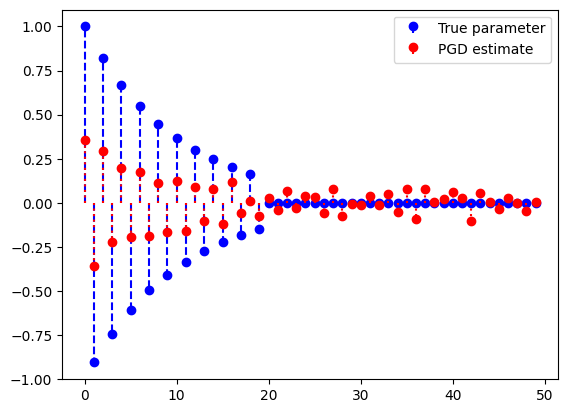

In [74]:
plt.stem(coefs, label="True parameter", linefmt='b--', markerfmt='bo', basefmt=' ')
plt.stem(x_PGD, label="PGD estimate", linefmt='r:', markerfmt='ro', basefmt=' ')
plt.legend()

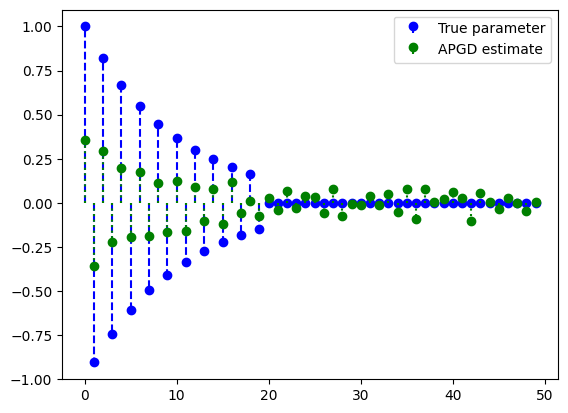

In [73]:
plt.stem(coefs, label="True parameter", linefmt='b--', markerfmt='bo', basefmt=' ')
plt.stem(x_APGD, label="APGD estimate", linefmt='g:', markerfmt='go', basefmt=' ')
plt.legend()

$\lambda=0.01$:

In [62]:
lmbd = 1e-2
x_PGD, obj_PGD, err_PGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1 / smoothness_const_linreg(A), lmbd, n_iter)
x_APGD, obj_APGD, err_APGD = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1 / smoothness_const_linreg(A), lmbd, n_iter)

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 4.47e-01 | 9.57e-01
      10 | 3.54e-01 | 7.56e-01
      20 | 3.46e-01 | 6.98e-01
      30 | 3.45e-01 | 6.78e-01
      40 | 3.45e-01 | 6.72e-01
      50 | 3.45e-01 | 6.69e-01
      60 | 3.45e-01 | 6.68e-01
      70 | 3.45e-01 | 6.68e-01
      80 | 3.45e-01 | 6.68e-01
      90 | 3.45e-01 | 6.68e-01
     100 | 3.45e-01 | 6.68e-01
     110 | 3.45e-01 | 6.68e-01
     120 | 3.45e-01 | 6.68e-01
     130 | 3.45e-01 | 6.68e-01
     140 | 3.45e-01 | 6.68e-01
     150 | 3.45e-01 | 6.68e-01
     160 | 3.45e-01 | 6.68e-01
     170 | 3.45e-01 | 6.68e-01
     180 | 3.45e-01 | 6.68e-01
     190 | 3.45e-01 | 6.68e-01
     200 | 3.45e-01 | 6.68e-01
     210 | 3.45e-01 | 6.68e-01
     220 | 3.45e-01 | 6.68e-01
     230 | 3.45e-01 | 6.68e-01
     240 | 3.45e-01 | 6.68e-01
     250 | 3.45e-01 | 6.68e-01
     260 | 3.45e-01 | 6.68e-01
     270 | 3.45e-01 | 6.68e-01
     280 | 3.45e-01 | 6.68e-01
     290 | 3.45e-01 | 6.68e-01
     300 | 3.45e-

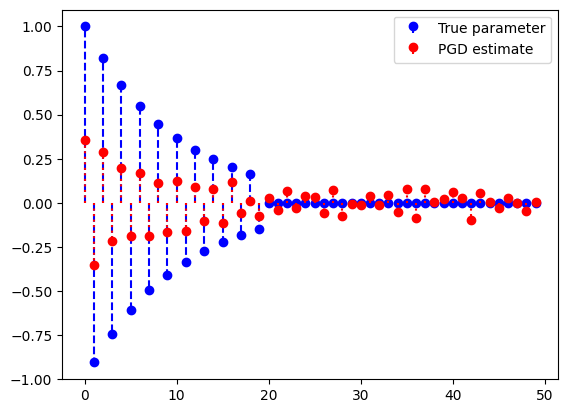

In [63]:
plt.stem(coefs, label="True parameter", linefmt='b--', markerfmt='bo', basefmt=' ')
plt.stem(x_PGD, label="PGD estimate", linefmt='r:', markerfmt='ro', basefmt=' ')
plt.legend()

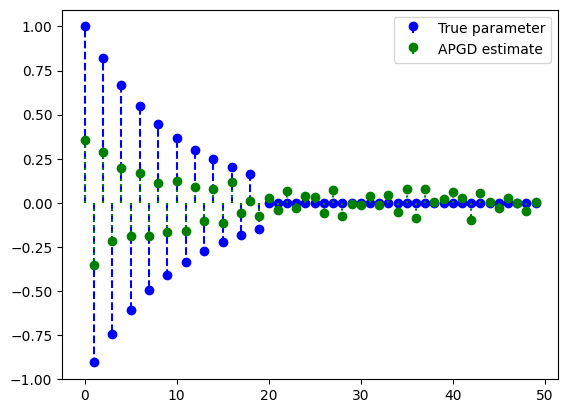

In [64]:
plt.stem(coefs, label="True parameter", linefmt='b--', markerfmt='bo', basefmt=' ')
plt.stem(x_APGD, label="APGD estimate", linefmt='g:', markerfmt='go', basefmt=' ')
plt.legend()

$\lambda=1$:

In [65]:
lmbd = 1
x_PGD, obj_PGD, err_PGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1 / smoothness_const_linreg(A), lmbd, n_iter)
x_APGD, obj_APGD, err_APGD = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1 / smoothness_const_linreg(A), lmbd, n_iter)

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 5.15e-01 | 9.63e-01
      10 | 5.71e-01 | 8.64e-01
      20 | 5.76e-01 | 8.57e-01
      30 | 5.76e-01 | 8.56e-01
      40 | 5.76e-01 | 8.56e-01
      50 | 5.76e-01 | 8.56e-01
      60 | 5.76e-01 | 8.56e-01
      70 | 5.76e-01 | 8.56e-01
      80 | 5.76e-01 | 8.56e-01
      90 | 5.76e-01 | 8.56e-01
     100 | 5.76e-01 | 8.56e-01
     110 | 5.76e-01 | 8.56e-01
     120 | 5.76e-01 | 8.56e-01
     130 | 5.76e-01 | 8.56e-01
     140 | 5.76e-01 | 8.56e-01
     150 | 5.76e-01 | 8.56e-01
     160 | 5.76e-01 | 8.56e-01
     170 | 5.76e-01 | 8.56e-01
     180 | 5.76e-01 | 8.56e-01
     190 | 5.76e-01 | 8.56e-01
     200 | 5.76e-01 | 8.56e-01
     210 | 5.76e-01 | 8.56e-01
     220 | 5.76e-01 | 8.56e-01
     230 | 5.76e-01 | 8.56e-01
     240 | 5.76e-01 | 8.56e-01
     250 | 5.76e-01 | 8.56e-01
     260 | 5.76e-01 | 8.56e-01
     270 | 5.76e-01 | 8.56e-01
     280 | 5.76e-01 | 8.56e-01
     290 | 5.76e-01 | 8.56e-01
     300 | 5.76e-

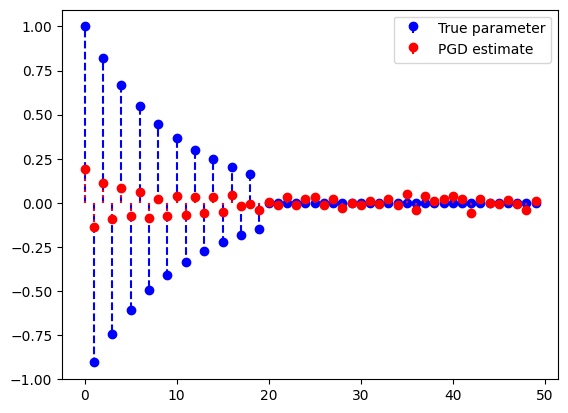

In [66]:
plt.stem(coefs, label="True parameter", linefmt='b--', markerfmt='bo', basefmt=' ')
plt.stem(x_PGD, label="PGD estimate", linefmt='r:', markerfmt='ro', basefmt=' ')
plt.legend()

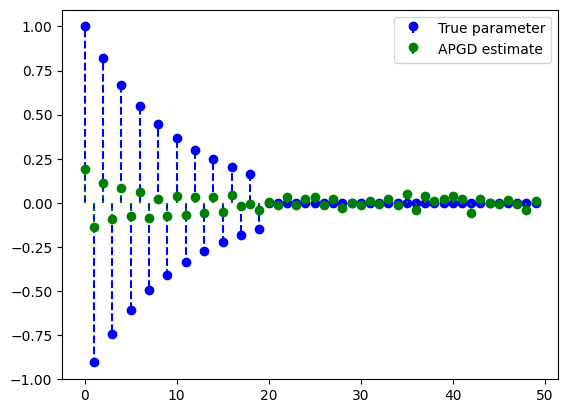

In [67]:
plt.stem(coefs, label="True parameter", linefmt='b--', markerfmt='bo', basefmt=' ')
plt.stem(x_APGD, label="APGD estimate", linefmt='g:', markerfmt='go', basefmt=' ')
plt.legend()

$\lambda=100$:

In [75]:
lmbd = 100
x_PGD, obj_PGD, err_PGD = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1 / smoothness_const_linreg(A), lmbd, n_iter)
x_APGD, obj_APGD, err_APGD = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1 / smoothness_const_linreg(A), lmbd, n_iter)

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 9.28e-01 | 9.97e-01
      10 | 9.43e-01 | 9.97e-01
      20 | 9.43e-01 | 9.97e-01
      30 | 9.43e-01 | 9.97e-01
      40 | 9.43e-01 | 9.97e-01
      50 | 9.43e-01 | 9.97e-01
      60 | 9.43e-01 | 9.97e-01
      70 | 9.43e-01 | 9.97e-01
      80 | 9.43e-01 | 9.97e-01
      90 | 9.43e-01 | 9.97e-01
     100 | 9.43e-01 | 9.97e-01
     110 | 9.43e-01 | 9.97e-01
     120 | 9.43e-01 | 9.97e-01
     130 | 9.43e-01 | 9.97e-01
     140 | 9.43e-01 | 9.97e-01
     150 | 9.43e-01 | 9.97e-01
     160 | 9.43e-01 | 9.97e-01
     170 | 9.43e-01 | 9.97e-01
     180 | 9.43e-01 | 9.97e-01
     190 | 9.43e-01 | 9.97e-01
     200 | 9.43e-01 | 9.97e-01
     210 | 9.43e-01 | 9.97e-01
     220 | 9.43e-01 | 9.97e-01
     230 | 9.43e-01 | 9.97e-01
     240 | 9.43e-01 | 9.97e-01
     250 | 9.43e-01 | 9.97e-01
     260 | 9.43e-01 | 9.97e-01
     270 | 9.43e-01 | 9.97e-01
     280 | 9.43e-01 | 9.97e-01
     290 | 9.43e-01 | 9.97e-01
     300 | 9.43e-

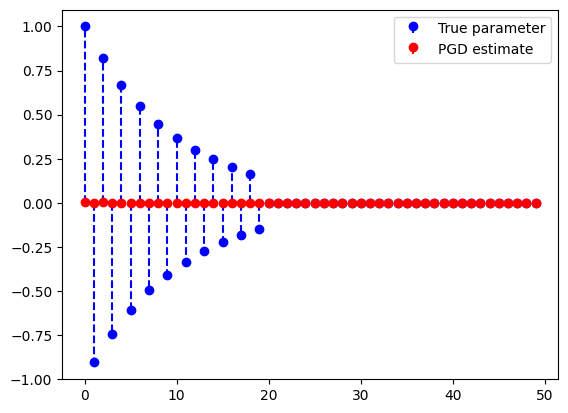

In [76]:
plt.stem(coefs, label="True parameter", linefmt='b--', markerfmt='bo', basefmt=' ')
plt.stem(x_PGD, label="PGD estimate", linefmt='r:', markerfmt='ro', basefmt=' ')
plt.legend()

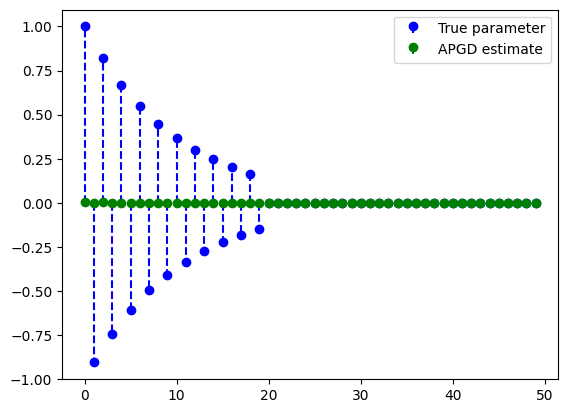

In [77]:
plt.stem(coefs, label="True parameter", linefmt='b--', markerfmt='bo', basefmt=' ')
plt.stem(x_APGD, label="APGD estimate", linefmt='g:', markerfmt='go', basefmt=' ')
plt.legend()

We can easily see that when the magnitude of $\lambda$ grows, it penalizes more on the norm of coefficients, so the coefficients becoming smaller and smaller when $\lambda$ becomes bigger and bigger, leading to all the coefficients becoming $0$ when $\lambda$ is too big.